In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_sch
import time

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size=100
valid_batch_size=1000
test_batch_size=10000

download_root = './data'

dataset = torchvision.datasets.CIFAR10(root = download_root, train=True,
                                      transform=transform, download=True)
trainset, validset = torch.utils.data.random_split(dataset, [45000,5000])

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=valid_batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root=download_root, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  0
TITAN Xp
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [5]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 이미지를 보여주기 위한 함수

# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# # 학습용 이미지를 무작위로 가져오기
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# # 이미지 보여주기
# imshow(torchvision.utils.make_grid(images))
# # 정답(label) 출력
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
'''Defining NN'''
from torch.nn.init import xavier_uniform_,uniform_


class Net(nn.Module):
    '''fc1_A shows d_p array that accumulates gradient updates
       fc1_c shows actual weight parameter array
       
       At the very first time, parameters of array A for all fc1,2,3
       have to be initialized to zero
       
       And then updtaed gradients will only be accumulated on A
       while leaving C array as it is until k==ns
       
       x: inputs
       '''
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features_A = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64,128,kernel_size=3, stride=1,padding=1,bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
        
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(128)
            )
#         for i in range(len(self.features_A)):
#             if type(self.features_A[i])==nn.Conv2d:
#                 torch.nn.init.zeros_(self.features_A[i].weight)
#                 if self.features_A[i].bias is not None:
#                     torch.nn.init.zeros_(self.features_A[i].bias)
                    
#         classname = self.features_A.__class__.__name__
#         if classname.find('Conv') != -1:
#             torch.nn.init.zeros_(self.features_A.weight)
            
        self.features_C = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64,128,kernel_size=3, stride=1,padding=1,bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
        
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(128)
            )
        self.classifier_A = nn.Sequential(
            nn.Linear(128*4*4, num_classes))
        self.classifier_A[0].weight.data.fill_(0)
#         if isinstance(self.classifier_A, nn.Linear):
#             nn.init.zeros_(self.classifier_A.weight)

#         for i in range(len(self.classifier_A)):
#             if type(self.classifier_A[i])==nn.Linear:
#                 torch.nn.init.zeros_(self.classifier_A[i].weight)
#                 if self.classifier_A[i].bias is not None:
#                     torch.nn.init.zeros_(self.classifier_A[i].bias)
        self.classifier_C = nn.Sequential(
            nn.Linear(128*4*4, num_classes))
#         import pdb; pdb.set_trace()
    
    
    def forward(self, x):
        gamma=1
        x = gamma*self.features_A(x)+self.features_C(x)
        x = x.view(x.size(0),-1)
        x = gamma*self.classifier_A(x) + self.classifier_C(x)
        return x

model = Net()
    
# def weights_init(m):
#         if isinstance(m, nn.Conv2d):
#             nn.init.zeros_(m.weight)
#             if m.bias is not None:
#                 nn.init.zeros_(m.bias)   
        
print(model)
# model.to(device)
# model.apply(weights_init)

Net(
  (features_A): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): BatchNorm2d(128, ep

In [7]:
# if torch.cuda.device_count()>1:
#     print("Let's use", torch.cuda.device_count(), "GPUS!")
#     model = nn.DataParallel(model)
model.to(device)

Net(
  (features_A): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): BatchNorm2d(128, ep

In [8]:
if type(model.children())==nn.Linear:
    model.children().weight.fill_(0.0)
params = list(model.children())
# print(params)
print(type(Net()))
# print(type(model.children()))

<class '__main__.Net'>


In [9]:
params=list(model.parameters())
print(params[0].size())
print(params[12].size())
for i in range(len(params)):
    print(f'{i}th parameter:{params[i]}')
    print(params[i].size()) 
    print("\n")
# params[0]=params[0].view(params[0].size()[0],-1)
# print(params[0].size())
# # for i in range(64):
# #     print(params[0][i])
# print(params[0])
# print(params[0][:,26].size())

torch.Size([64, 3, 3, 3])
torch.Size([64, 3, 3, 3])
0th parameter:Parameter containing:
tensor([[[[ 0.1341,  0.0823, -0.1250],
          [-0.1837,  0.0800,  0.1381],
          [-0.0719,  0.0988, -0.1503]],

         [[ 0.0223,  0.0232, -0.1303],
          [-0.1196,  0.1263,  0.0268],
          [ 0.1151,  0.1589, -0.0684]],

         [[ 0.1017, -0.1225,  0.1417],
          [ 0.0622,  0.0065, -0.0376],
          [ 0.1862,  0.1509,  0.1833]]],


        [[[ 0.0464,  0.1040, -0.1041],
          [-0.1658, -0.0342,  0.0293],
          [ 0.0646,  0.1536, -0.0286]],

         [[-0.1057, -0.1644,  0.0537],
          [ 0.1793, -0.0094,  0.1742],
          [ 0.1126, -0.1913, -0.0216]],

         [[-0.0922, -0.0092, -0.0259],
          [ 0.0740,  0.1916,  0.1500],
          [ 0.1202, -0.1164,  0.0646]]],


        [[[ 0.1302,  0.1298, -0.0633],
          [ 0.1641, -0.1608, -0.0030],
          [ 0.1517,  0.0443,  0.1603]],

         [[-0.1260, -0.1202,  0.0493],
          [ 0.0650,  0.1394, -0.1427

In [10]:
t = torch.tensor([[[1, 2],
                       [3, 4]],
                      [[5, 6],
                       [7, 8]]])
print(t.size())
# t.flatten_()
# t=torch.flatten(t,start_dim=0)
t=t.view(t.size()[0],-1)
print(t)
print(t.size())
t=t.view(t.size()[0],2,2)
print(t)
print(t.size())

torch.Size([2, 2, 2])
tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])
torch.Size([2, 4])
tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])
torch.Size([2, 2, 2])


In [11]:
'''Custom Optimizer'''
'''tiki-taka's asymmetric characteristic simulated here'''

from torch.optim.optimizer import Optimizer, required
# import copy
from torch.nn.init import xavier_uniform_, zeros_
# from torch.nn.modules.linear import reset_parameters

class Tiki_Taka(Optimizer, Net):
    """Implements RPU based SGD algorithm
    Parameters:...
    
    """
    
    def __init__(self, params, lr = required, momentum =0, dampening =0, weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay<0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov)
        super(Tiki_Taka, self).__init__(params, defaults)
        self.update_count = 0

    def __setstate__(self, state):
        super(Tiki_Taka, self).__setstate__(state)
        
#     ns=0
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step"""
        
        loss =None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
        
            counter=0
            for p in group['params']:
#                 import pdb;pdb.set_trace()
                if p.grad is None:
                    continue
                
                d_p=p.grad

                if counter in [0,3,6,9,24,25]:

                    asym=1+1.66*p
                    asym2=1-1.66*p
                    new=F.relu(torch.sign(d_p), inplace=False)
                    new2=F.relu(-torch.sign(d_p), inplace=False)
                    mul = new.mul(asym)
                    mul2=new2.mul(asym2)
#                     import pdb;pdb.set_trace()

                    p.add_(torch.mul(mul,d_p),alpha=-group['lr']).add_(torch.mul(mul2,d_p),alpha=-group['lr'])
#                     import pdb;pdb.set_trace()
                   
                    counter+=1      
                elif counter in [12,15,18,21,26,27]:
#                     import pdb;pdb.set_trace()

                    counter+=1
                else:
#                     import pdb;pdb.set_trace()

                    p.add_(d_p, alpha=-group['lr'])
#                     import pdb;pdb.set_trace()

                    counter+=1
                    continue
        return loss 
    
    
    @torch.no_grad()
    def update(self, closure=None, count=[0]):
        """Performs a second optimization step
        alpha here signifies lambda value in Tiki-Taka"""
        
        loss =None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']


            if self.update_count<27:
                group['params'][0]=group['params'][0].view(group['params'][0].size()[0],-1)
                group['params'][12]=group['params'][12].view(group['params'][12].size()[0],-1)

                asym=group['params'][12][:,self.update_count]*1.66+1
                asym2=1-1.66*group['params'][12][:,self.update_count]
                new=F.relu(torch.sign(group['params'][0][:,self.update_count]), inplace=False)

                new2=F.relu(-torch.sign(group['params'][0][:,self.update_count]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][12][:,self.update_count].add_(torch.mul(mul,group['params'][0][:,self.update_count]), alpha=-0.02).add_(torch.mul(mul2,group['params'][0][:,self.update_count]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][0][:,self.update_count])
                group['params'][0]=group['params'][0].view(group['params'][0].size()[0],3,3,3)
                group['params'][12]=group['params'][12].view(group['params'][12].size()[0],3,3,3)
                self.update_count+=1
            

            elif self.update_count>=27 and self.update_count<603:
                group['params'][3]=group['params'][3].view(group['params'][3].size()[0],-1)
                group['params'][15]=group['params'][15].view(group['params'][15].size()[0],-1)

                asym=1+1.66*group['params'][15][:,self.update_count-27]
                asym2=1-1.66*group['params'][15][:,self.update_count-27]
                new=F.relu(torch.sign(group['params'][3][:,self.update_count-27]), inplace=False)
                new2=F.relu(-torch.sign(group['params'][3][:,self.update_count-27]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][15][:,self.update_count-27].add_(torch.mul(mul,group['params'][3][:,self.update_count-27]), alpha=-0.02).add_(torch.mul(mul2,group['params'][3][:,self.update_count-27]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][4][:,self.update_count-27])
                group['params'][3]=group['params'][3].view(group['params'][3].size()[0],64,3,3)
                group['params'][15]=group['params'][15].view(group['params'][15].size()[0],64,3,3)

                self.update_count+=1

            elif self.update_count>=603 and self.update_count<1179:
                group['params'][6]=group['params'][6].view(group['params'][6].size()[0],-1)
                group['params'][18]=group['params'][18].view(group['params'][18].size()[0],-1)

                asym=1+1.66*group['params'][18][:,self.update_count-603]
                asym2=1-1.66*group['params'][18][:,self.update_count-603]
                new=F.relu(torch.sign(group['params'][6][:,self.update_count-603]), inplace=False)
                new2=F.relu(-torch.sign(group['params'][6][:,self.update_count-603]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][18][:,self.update_count-603].add_(torch.mul(mul,group['params'][6][:,self.update_count-603]), alpha=-0.02).add_(torch.mul(mul2,group['params'][6][:,self.update_count-603]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][8][:,self.update_count-603])
                group['params'][6]=group['params'][6].view(group['params'][6].size()[0],64,3,3)
                group['params'][18]=group['params'][18].view(group['params'][18].size()[0],64,3,3)

                self.update_count+=1
    
            elif self.update_count>=1179 and self.update_count<2331:
                group['params'][9]=group['params'][9].view(group['params'][9].size()[0],-1)
                group['params'][21]=group['params'][21].view(group['params'][21].size()[0],-1)

                asym=1+1.66*group['params'][21][:,self.update_count-1179]
                asym2=1-1.66*group['params'][21][:,self.update_count-1179]
                new=F.relu(torch.sign(group['params'][9][:,self.update_count-1179]), inplace=False)
                new2=F.relu(-torch.sign(group['params'][9][:,self.update_count-1179]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][21][:,self.update_count-1179].add_(torch.mul(mul,group['params'][9][:,self.update_count-1179]), alpha=-0.02).add_(torch.mul(mul2,group['params'][9][:,self.update_count-1179]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][8][:,self.update_count-603])
                group['params'][9]=group['params'][9].view(group['params'][9].size()[0],128,3,3)
                group['params'][21]=group['params'][21].view(group['params'][21].size()[0],128,3,3)

                self.update_count+=1
    
            elif self.update_count>=2331 and self.update_count<2341:
                asym=1+1.66*group['params'][26][self.update_count-2331]
                asym2=1-1.66*group['params'][26][self.update_count-2331]
                new=F.relu(torch.sign(group['params'][24][self.update_count-2331]), inplace=False)
                new2=F.relu(-torch.sign(group['params'][24][self.update_count-2331]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][26][self.update_count-2331].add_(torch.mul(mul,group['params'][24][self.update_count-2331]), alpha=-0.02).add_(torch.mul(mul2,group['params'][24][self.update_count-2331]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][8][:,self.update_count-603])
                self.update_count+=1
            
            elif self.update_count==2341:
                asym=1+1.66*group['params'][27]
                asym2=1-1.66*group['params'][27]
                new=F.relu(torch.sign(group['params'][25]), inplace=False)
                new2=F.relu(-torch.sign(group['params'][25]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][27].add_(torch.mul(mul,group['params'][25]), alpha=-0.02).add_(torch.mul(mul2,group['params'][25]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][9])               
                self.update_count=0
            else:
                assert False, "Don't go here"

In [12]:
'''Loss function and Optimizer'''

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = Tiki_Taka(model.parameters(), lr=learning_rate)

In [13]:
len(valid_loader)

5

In [14]:
def train_model(model, batch_size, patience, n_epochs):
    model.to(device)
    # to track the training loss as the model trains
    train_losses = []
    train_accuracies=[]
    # to track the validation loss as the model trains
    valid_losses = []
    valid_accuracies=[]
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    avg_train_accuracies=[]
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    avg_valid_accuracies=[]
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    scheduler = lr_sch.MultiStepLR(optimizer, milestones=[1,4,5,7,8,10],gamma=0.8)

    for epoch in range(1, n_epochs + 1):
        ns=0
        correct=0
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, data in enumerate(train_loader, 1):
            inputs,target = data[0].to(device), data[1].to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            if ns%30==29:
#         if ns>0:
                optimizer.update()
            # record training loss
            train_losses.append(loss.item())
#             print(train_losses)
#             print(type(train_losses))
            pred=output.data.max(1,keepdim=True)[1]
            correct=sum(pred.eq(target.data.view_as(pred)))*100./batch_size
            train_accuracies.append(correct.item())
#             print(correct)
#             print(correct.item())
            ns+=1
            
            if batch%1000==0:
                train_loss=sum(train_losses[batch-1000:batch])/1000.
                train_acc=sum(train_accuracies[batch-1000:batch])/1000.
                print_inter=(f'epoch:{epoch}/{n_epochs} ' +
                      f'step:{batch}/{len(train_loader)} ' +
                      f'loss:{train_loss:.4f} '
                      f'accuracy:{train_acc:.4f}'
                     )
                print(print_inter)
            
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        with torch.no_grad():    
            for data in valid_loader:
                inputs,target = data[0].to(device), data[1].to(device)
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(inputs)
                # calculate the loss
                loss = criterion(output, target)
                # record validation loss
                valid_losses.append(loss.item())
                pred=output.data.max(1,keepdim=True)[1]
                correct=sum(pred.eq(target.data.view_as(pred)))*100./valid_batch_size
                valid_accuracies.append(correct.item())
#             import pdb;pdb.set_trace()
        print(f"lr:{optimizer.param_groups[0]['lr']}")
        
        scheduler.step()
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        train_accuracy=np.average(train_accuracies)
        valid_loss = np.average(valid_losses)
        valid_accuracy=np.average(valid_accuracies)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_train_accuracies.append(train_accuracy)
        avg_valid_accuracies.append(valid_accuracy)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}'+
                    f'train_accuracy:{train_accuracy:.5f}'+
                    f'valid_accuracy:{valid_accuracy:.5f}')
        
        print(print_msg)
#         import pdb;pdb.set_trace()

        # clear lists to track next epoch
        train_losses = []
        train_accuracies=[]
        valid_losses = []
        valid_accuracies=[]
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_accuracy, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
#         torch.cuda.empty_cache()
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses, avg_train_accuracies, avg_valid_accuracies

In [15]:
# model.to(device)

n_epochs = 30

train_loader, test_loader, valid_loader 

# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

model, train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, batch_size, patience, n_epochs)

lr:0.01
[ 1/30] train_loss: 1.19153 valid_loss: 1.00916train_accuracy:57.86889valid_accuracy:65.14000
Validation loss decreased (inf --> 65.140005).  Saving model ...
lr:0.008
[ 2/30] train_loss: 0.78538 valid_loss: 0.86586train_accuracy:72.78889valid_accuracy:70.76000
Validation loss decreased (65.140005 --> 70.760004).  Saving model ...
lr:0.008
[ 3/30] train_loss: 0.60800 valid_loss: 0.84765train_accuracy:79.47556valid_accuracy:71.86000
Validation loss decreased (70.760004 --> 71.860002).  Saving model ...
lr:0.008
[ 4/30] train_loss: 0.48372 valid_loss: 0.84965train_accuracy:83.86667valid_accuracy:72.30000
Validation loss decreased (71.860002 --> 72.300003).  Saving model ...
lr:0.0064
[ 5/30] train_loss: 0.35956 valid_loss: 0.85603train_accuracy:88.95333valid_accuracy:72.68000
Validation loss decreased (72.300003 --> 72.680003).  Saving model ...
lr:0.00512
[ 6/30] train_loss: 0.26527 valid_loss: 0.85551train_accuracy:92.95778valid_accuracy:72.72000
Validation loss decreased (72.6

In [16]:
# PATH = "cifar10.pt"
# torch.save(model.state_dict(),PATH)
# torch.save(model.module.state_dict(), PATH)

In [17]:
torch.cuda.empty_cache()

In [18]:
print(valid_loss)
print(train_loss)

[1.0091642141342163, 0.8658557772636414, 0.8476454496383667, 0.8496529340744019, 0.856030011177063, 0.8555091023445129, 0.8832132458686829, 0.8806047916412354, 0.8994194269180298, 0.9097179889678955, 0.9253580331802368, 0.9329177141189575, 0.9406670451164245, 0.9466103434562683, 0.9553968787193299, 0.9718927383422852, 0.9780387163162232, 0.9879682898521424]
[1.1915303795867496, 0.7853760276900398, 0.6080008646514681, 0.48372155911392634, 0.3595615454514821, 0.26527412318521076, 0.21112751020325554, 0.1557205060786671, 0.12173194181587961, 0.10245436447362105, 0.08470242943200801, 0.07521438445481989, 0.06718261374367608, 0.05936969099773301, 0.05386348187095589, 0.04852256681356165, 0.0441347652218408, 0.039685885993142926]


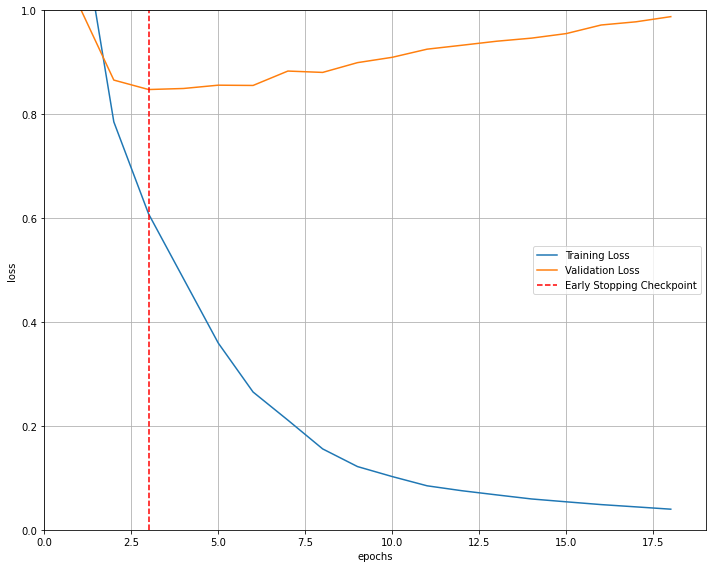

In [19]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')


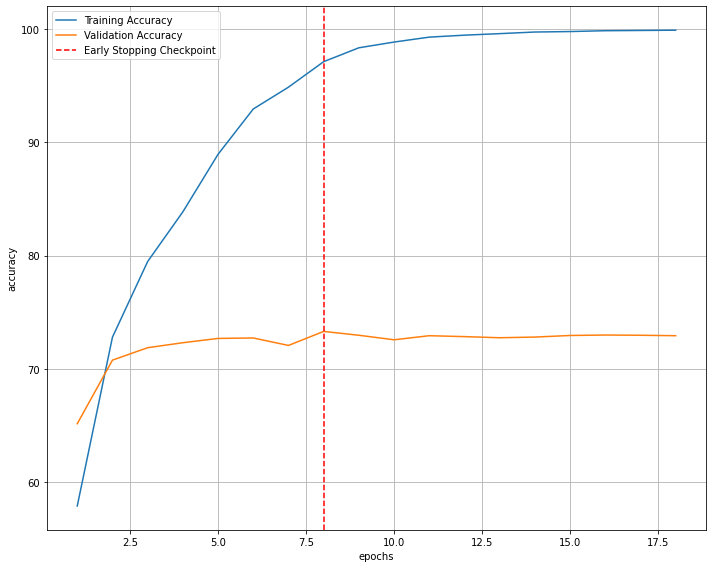

In [20]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, label='Training Accuracy')
plt.plot(range(1,len(valid_accuracy)+1),valid_accuracy,label='Validation Accuracy')

# find position of lowest validation loss
maxposs = valid_accuracy.index(max(valid_accuracy))+1 
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
# plt.ylim(0, 0.5) # consistent scale
# plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('accuracy_plot.png', bbox_inches='tight')


In [21]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# device=torch.device("cuda")
# model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
model.to(device)
model.eval() # prep model for evaluation
with torch.no_grad():
    for data in test_loader:
        inputs,target = data[0].to(device), data[1].to(device)

        if len(target.data) != test_batch_size:
            break
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(inputs)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*inputs.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(test_batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# labels = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(classes[i]), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
torch.cuda.empty_cache()

Test Loss: 1.403628

Test Accuracy of plane: 58% (588/1000)
Test Accuracy of   car: 72% (724/1000)
Test Accuracy of  bird: 24% (243/1000)
Test Accuracy of   cat: 40% (400/1000)
Test Accuracy of  deer: 49% (491/1000)
Test Accuracy of   dog: 45% (454/1000)
Test Accuracy of  frog: 43% (431/1000)
Test Accuracy of horse: 57% (578/1000)
Test Accuracy of  ship: 65% (656/1000)
Test Accuracy of truck: 54% (546/1000)

Test Accuracy (Overall): 51% (5111/10000)
